This program works 9 April 2025

In [ ]:
#Formats output window
from IPython.display import HTML

HTML('''
<style>
  /* make all output areas expand to fit their contents */
  div.output_scroll {
    height: auto !important;
    max-height: none !important;
  }
</style>
''')

Enter first element's atomic symbol:Cu
Enter second element's atomic symbol:La


Retrieving ThermoDoc documents:   0%|          | 0/18 [00:00<?, ?it/s]

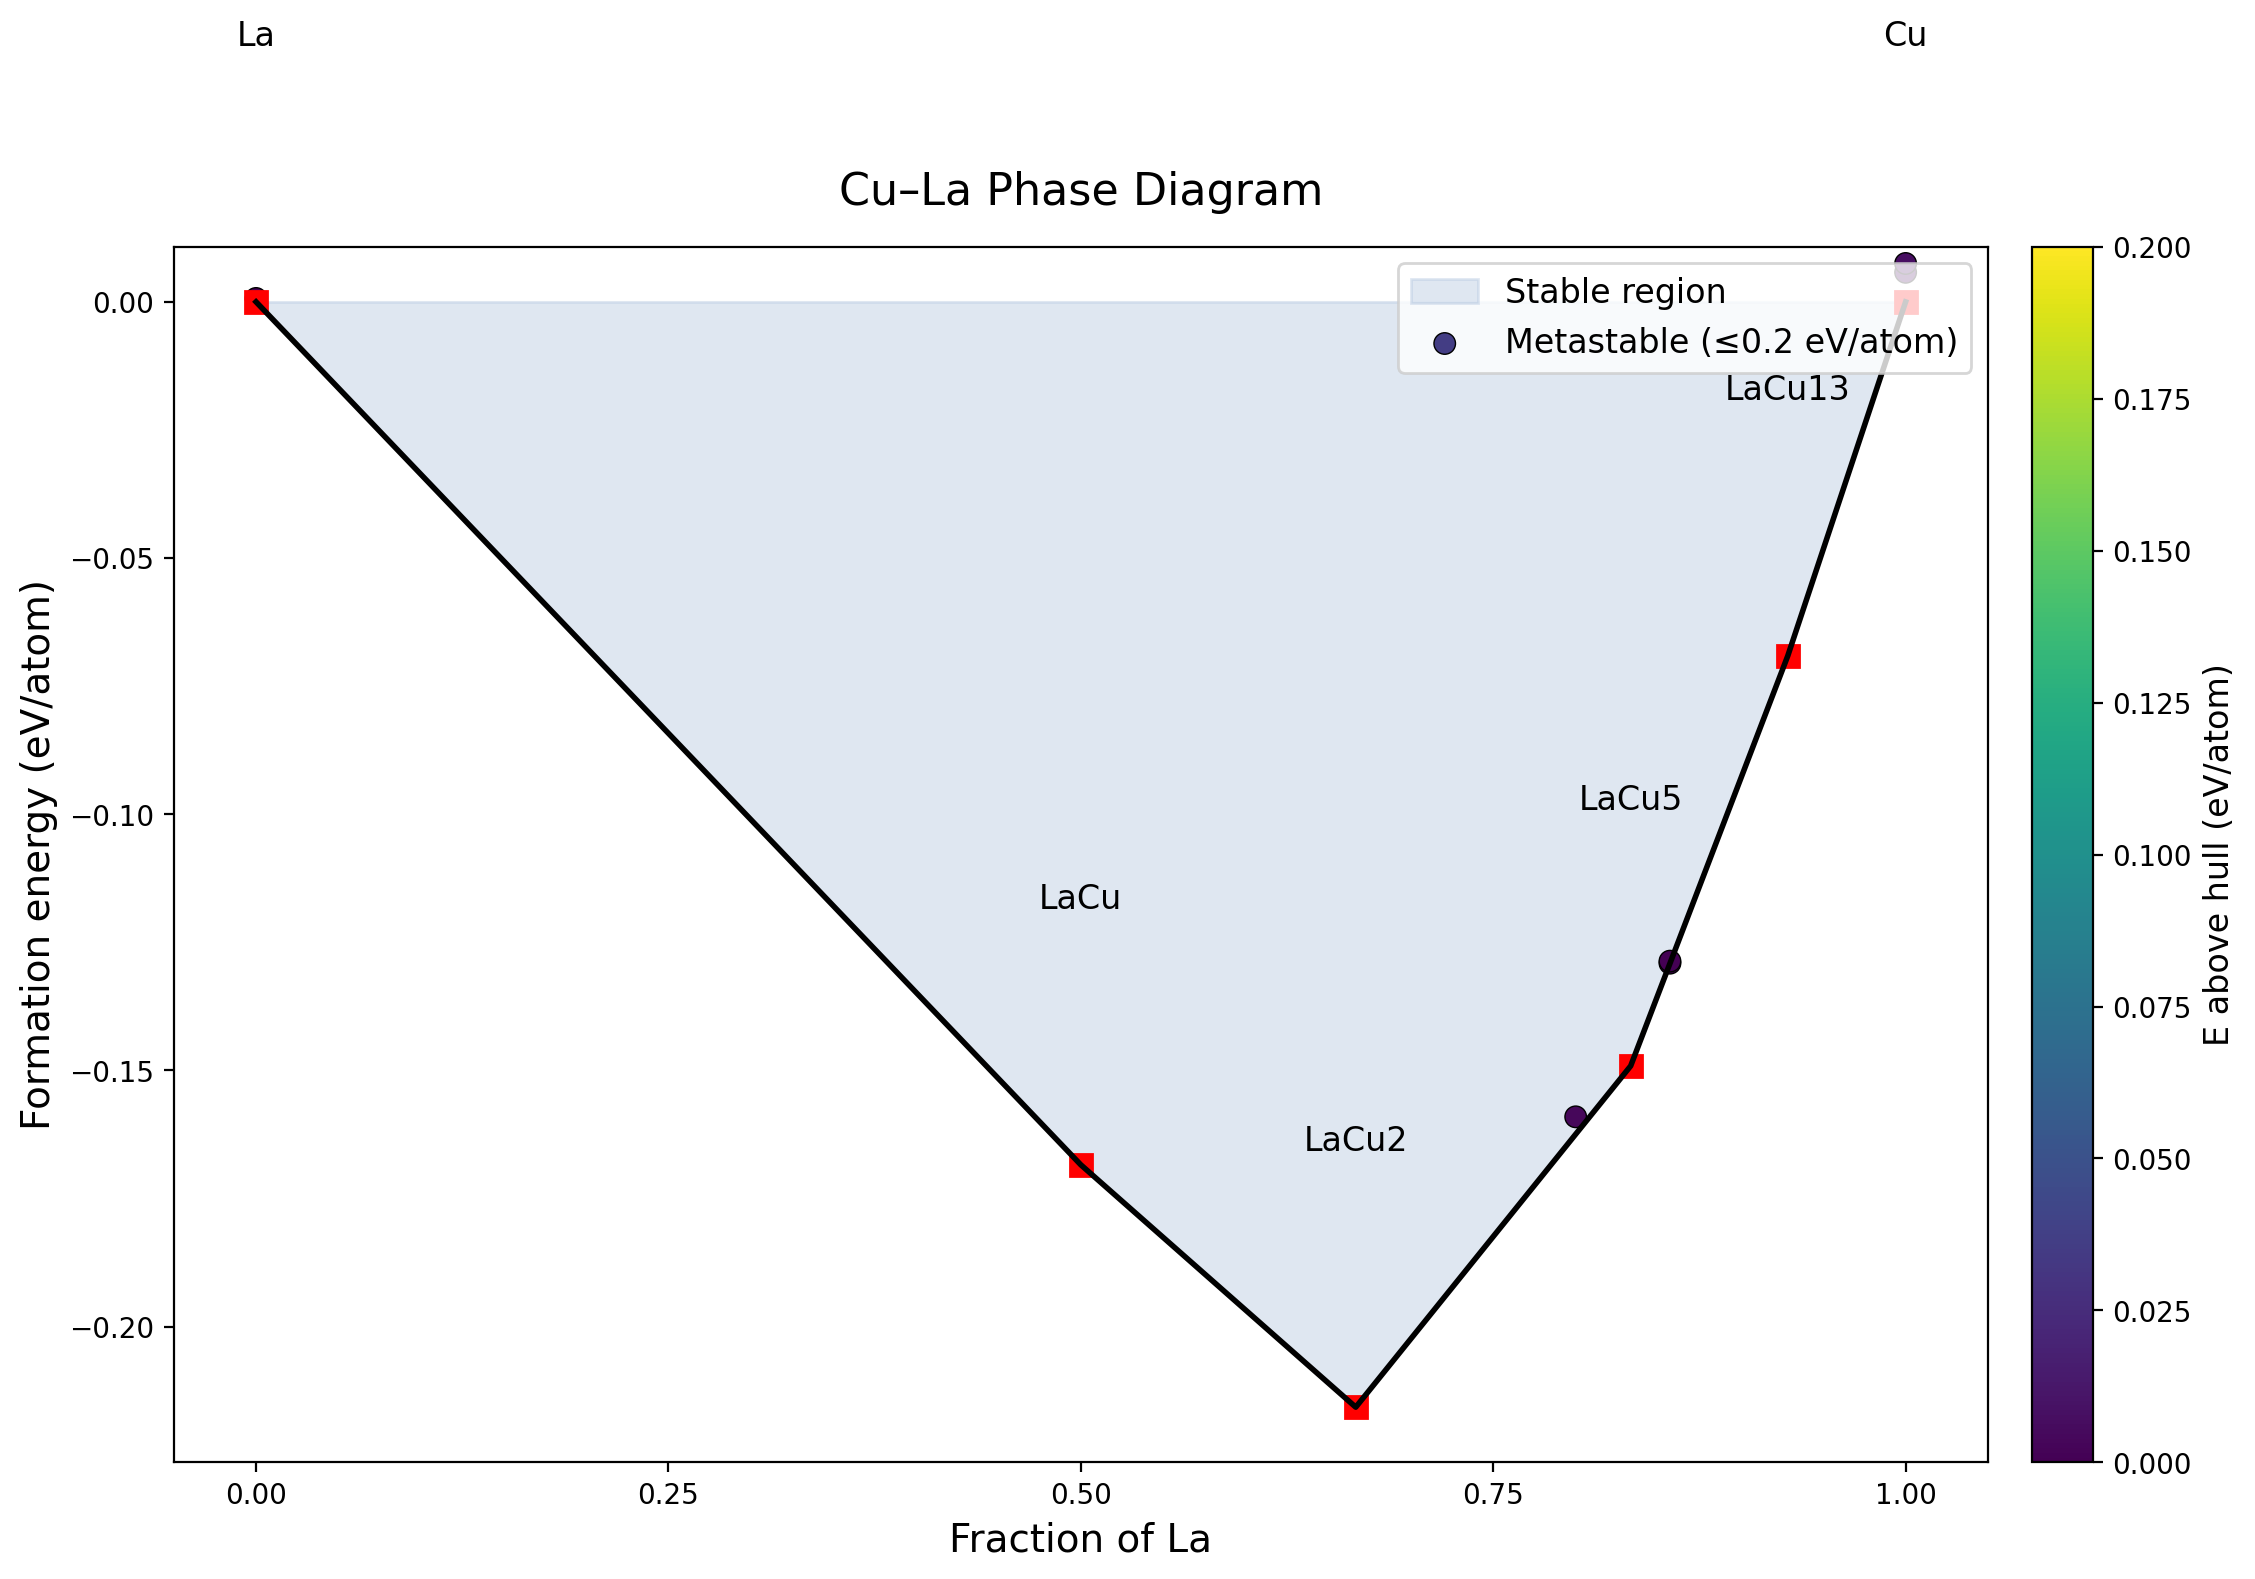

Number of stable phases: 6
Stable phases:
  LaCu
  LaCu2
  LaCu5
  Cu
  La
  LaCu13

Stable compositions with formation energies:
  LaCu: -0.168 eV/atom
  LaCu2: -0.216 eV/atom
  LaCu5: -0.149 eV/atom
  LaCu13: -0.069 eV/atom


In [ ]:
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.analysis.phase_diagram import PDPlotter
from IPython.display import HTML



# Make sure plots appear in the notebook
%matplotlib inline
# For higher resolution plots
%config InlineBackend.figure_format = 'retina'

# Replace with your Materials Project API key
API_KEY = "YOUR API KEY"

# Define the binary system to analyze
element1 = input("Enter first element's atomic symbol:").strip().capitalize()
element2 = input("Enter second element's atomic symbol:").strip().capitalize()
chemsys  = [element1, element2]

# Connect to the Materials Project database
with MPRester(API_KEY) as mpr:
    # Get all entries in the binary system
    entries = mpr.get_entries_in_chemsys(chemsys)

    # Create a phase diagram
    phase_diagram = PhaseDiagram(entries)

    # We'll create a new, customized plot entirely from scratch
    # This way we have complete control over the appearance

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Plot all entries
    for entry in entries:
        # Get composition and energy
        comp = entry.composition
        # Calculate fraction of second element
        if comp.is_element:
            if comp.elements[0] == phase_diagram.elements[1]:
                x = 1.0
            else:
                x = 0.0
        else:
            x = comp.get_atomic_fraction(phase_diagram.elements[1])

        # Get formation energy
        if comp.is_element:
            y = 0
        else:
            y = phase_diagram.get_form_energy_per_atom(entry)

        # Plot stable entries as red squares, unstable as smaller blue circles
        if entry in phase_diagram.stable_entries:
            plt.plot(x, y, 'rs', markersize=8)
            # Add text label slightly offset from the point
            plt.text(x, y+0.05, entry.name, fontsize=12, ha='center')
        else:
            e_above_hull = phase_diagram.get_e_above_hull(entry)


    # Plot the convex hull by connecting stable entries
    # First, collect all stable points
    hull_xs = []
    hull_ys = []

    for entry in phase_diagram.stable_entries:
        # Get composition
        comp = entry.composition
        # Calculate fraction of second element
        if comp.is_element:
            if comp.elements[0] == phase_diagram.elements[1]:
                x = 1.0
            else:
                x = 0.0
        else:
            x = comp.get_atomic_fraction(phase_diagram.elements[1])

        # Get formation energy
        if comp.is_element:
            y = 0
        else:
            y = phase_diagram.get_form_energy_per_atom(entry)

        hull_xs.append(x)
        hull_ys.append(y)

    # Sort the hull points by x-coordinate
    hull_points = sorted(zip(hull_xs, hull_ys))
    hull_xs = [point[0] for point in hull_points]
    hull_ys = [point[1] for point in hull_points]

    # Draw the convex hull
    plt.plot(hull_xs, hull_ys, 'k-', linewidth=2)

    # Add title and labels
    plt.title(f"{element1}-{element2} Binary Phase Diagram", fontsize=16)
    plt.xlabel(f"Fraction of {element2}", fontsize=14)
    plt.ylabel("Formation energy (eV/atom)", fontsize=14)


plt.style.use('seaborn-v0_8-muted')


plt.fill_between(hull_xs, hull_ys,
                 color="lightsteelblue", alpha=0.4,
                 label="Stable region")


xs, ys, es = [], [], []
for entry in entries:
    if entry not in phase_diagram.stable_entries:
        e_above = phase_diagram.get_e_above_hull(entry)
        if e_above < 0.2:
            xs.append(entry.composition.get_atomic_fraction(phase_diagram.elements[1]))
            ys.append(phase_diagram.get_form_energy_per_atom(entry))
            es.append(e_above)


norm = Normalize(vmin=0, vmax=0.2)
sc = plt.scatter(xs, ys, c=es, cmap='viridis', norm=norm,
                   s=60, edgecolor='k', linewidth=0.5,
                   label="Metastable (≤0.2 eV/atom)")


ax = plt.gca()
ax.relim()
ax.autoscale_view()

  #colorbar for the above scatter
cbar = plt.colorbar(sc, ax=ax, pad=0.02)
cbar.set_label("E above hull (eV/atom)", fontsize=12)

from matplotlib.cm import viridis
from matplotlib.colors import Normalize


meta_points = [
    (entry, phase_diagram.get_e_above_hull(entry))
    for entry in entries
    if entry not in phase_diagram.stable_entries
    and phase_diagram.get_e_above_hull(entry) < 0.2]




ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=norm, cmap=viridis)
sm.set_array([])

#Formatting
plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel(f"Fraction of {element2}", fontsize=14)
plt.ylabel("Formation energy (eV/atom)", fontsize=14)
plt.title(f"{element1}–{element2} Phase Diagram", fontsize=16, pad=15)
plt.legend(loc="upper right", frameon=True, fontsize=12)


plt.tight_layout()
plt.show()



# Print information about the stable phases
stable_entries = phase_diagram.stable_entries
print(f"Number of stable phases: {len(stable_entries)}")
print("Stable phases:")
for entry in stable_entries:
    print(f"  {entry.name}")

# Calculate and print formation energies
print("\nStable compositions with formation energies:")
for entry in stable_entries:
    if not entry.composition.is_element:  # Skip the pure elements
        form_e = phase_diagram.get_form_energy_per_atom(entry)
        print(f"  {entry.name}: {form_e:.3f} eV/atom")